## Random Forest

In [3]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [4]:
# Load the dataset
df = pd.read_csv('https://drive.google.com/uc?id=1sbFAHLYmyOBhHZ8yHqct2yhViRRV9r3u')

In [5]:
print(df.shape)
df.head()


(407140, 12)


,TimeStamp,WindSpeed_Mean,VoltL1_Mean,VoltL2_Mean,VoltL3_Mean,ActivePower_Mean,CurrentL1_Mean,CurrentL2_Mean,CurrentL3_Mean,PowerFactor_Mean,Frequency_Mean,WindSpeed_Bin
0,2016-01-01 00:00:00,6.785655,392.817993,393.226410,392.404510,521.591797,588.076599,588.153687,588.288208,0.735540,50.030361,6.8
1,2016-01-01 00:10:00,6.085925,392.750610,393.095093,392.344208,352.522308,491.073486,491.226807,491.788910,0.564326,49.993130,6.1
2,2016-01-01 00:20:00,5.824687,393.093109,393.321503,392.433807,294.078888,472.158508,472.661804,472.771088,0.512421,49.952190,5.8
3,2016-01-01 00:30:00,7.100197,393.863586,394.046600,393.028595,587.302795,674.494019,674.627991,674.614319,0.705167,49.975941,7.1
4,2016-01-01 00:40:00,8.232280,394.487793,394.654785,393.713715,881.533325,866.352600,866.474121,865.911682,0.840677,49.930500,8.2


In [6]:
df = df.drop(columns=['TimeStamp','WindSpeed_Bin'])

### Model

In [12]:
class RandomForestRegressorModel:
    def __init__(self, params=None):
        self.params = {
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'auto',  # or 'sqrt', 'log2'
            'random_state': 42,
            'n_jobs': -1
        }
        if params:
            self.params.update(params)

        self.model = None

    def _evaluate(self, y_true, y_pred):
        eps = 1e-2
        mask = y_true > eps

        if np.sum(mask) == 0:
            print("[Warning] No valid values after masking low y_true values.")
            return {}

        y_true = y_true[mask]
        y_pred = y_pred[mask]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y = np.mean(y_true)
        rmsep_approx = (rmse / mean_y) * 100
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        smape = np.mean(2.0 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + eps)) * 100

        return {
            'RMSE': rmse,
            'RMSEP_approx (%)': rmsep_approx,
            'R2': r2,
            'MAE': mae,
            'SMAPE (%)': smape
        }

    def run(self, df, target_column='ActivePower_Mean'):
        X = df.drop(columns=[target_column])
        y = df[target_column].values

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

        self.model = RandomForestRegressor(**self.params)
        self.model.fit(X_train, y_train)

        y_train_pred = self.model.predict(X_train)
        y_val_pred   = self.model.predict(X_val)
        y_test_pred  = self.model.predict(X_test)

        train_metrics = self._evaluate(y_train, y_train_pred)
        val_metrics   = self._evaluate(y_val,   y_val_pred)
        test_metrics  = self._evaluate(y_test,  y_test_pred)

        print("Training Metrics:   ", train_metrics)
        print("Validation Metrics: ", val_metrics)
        print("Test Metrics:       ", test_metrics)

        return {
            'train': train_metrics,
            'val':   val_metrics,
            'test':  test_metrics
        }

    def grid_search(self, df, target_column='ActivePower_Mean', param_grid=None, primary_metric='RMSE'):
        X = df.drop(columns=[target_column])
        y = df[target_column].values

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
        X_val, _, y_val, _ = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

        all_results = []

        keys, values = zip(*param_grid.items())
        for combo in product(*values):
            trial_params = dict(zip(keys, combo))

            model = RandomForestRegressor(**trial_params, random_state=42, n_jobs=-1)
            model.fit(X_train, y_train)

            y_val_pred = model.predict(X_val)
            metrics = self._evaluate(y_val, y_val_pred)

            all_results.append({
                'params': trial_params.copy(),
                'metrics': metrics
            })

        self.all_results = all_results


        best = min(all_results, key=lambda r: r['metrics'][primary_metric])
        print(f"Best params by {primary_metric}: {best['params']}")
        print(f"{primary_metric} = {best['metrics'][primary_metric]:.4f}")

        return best, all_results

    def learning_curve(self, df, target_column='ActivePower_Mean', metric='RMSE', train_sizes=None):
        if train_sizes is None:
            train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

        X = df.drop(columns=[target_column])
        y = df[target_column].values

        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
        X_val, _, y_val, _ = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

        scores = []

        for frac in train_sizes:
            n_samples = int(frac * len(X_train))
            X_subset = X_train[:n_samples]
            y_subset = y_train[:n_samples]

            model = RandomForestRegressor(**self.params)
            model.fit(X_subset, y_subset)

            y_val_pred = model.predict(X_val)
            score = self._evaluate(y_val, y_val_pred)[metric]
            print(f"Train size: {n_samples}, {metric}: {score:.4f}")
            scores.append(score)

        # Plot learning curve
        plt.figure(figsize=(8, 5))
        plt.plot([int(frac * 100) for frac in train_sizes], scores, marker='o')
        plt.xlabel("Training Size (%)")
        plt.ylabel(metric)
        plt.title(f"Learning Curve - {metric}")
        plt.grid(True)
        plt.show()

    def export_results(self, filename='rf_grid_results.xlsx'):
        rows = [
            {**trial['params'], **trial['metrics']}
            for trial in self.all_results
        ]
        df_results = pd.DataFrame(rows)
        df_results = df_results.sort_values('RMSE').reset_index(drop=True)
        df_results.to_excel(filename, index=False)
        print(f"Results saved to {filename}")
        return df_results


### Application on Small Dataset

Best params by RMSE: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
RMSE = 9.5920
Results saved to rf_grid_results_small.xlsx
Training Metrics:    {'RMSE': np.float64(5.528186806068248), 'RMSEP_approx (%)': np.float64(0.7354311942163146), 'R2': 0.9999401604284719, 'MAE': 2.749528522877518, 'SMAPE (%)': np.float64(2.6372352626382405)}
Validation Metrics:  {'RMSE': np.float64(9.591956534506382), 'RMSEP_approx (%)': np.float64(1.2864330146354652), 'R2': 0.9998214668751783, 'MAE': 5.2891050524175505, 'SMAPE (%)': np.float64(4.900042733426946)}
Test Metrics:        {'RMSE': np.float64(13.102933994155276), 'RMSEP_approx (%)': np.float64(1.717208480447963), 'R2': 0.9996693850490023, 'MAE': 5.594464336532958, 'SMAPE (%)': np.float64(4.7413669682644)}
Train size: 2849, RMSE: 15.8277
Train size: 8549, RMSE: 11.8262
Train size: 14249, RMSE: 10.7025
Train size: 19949, RMSE: 10.0463
Train size: 28499, RMSE: 9.5920


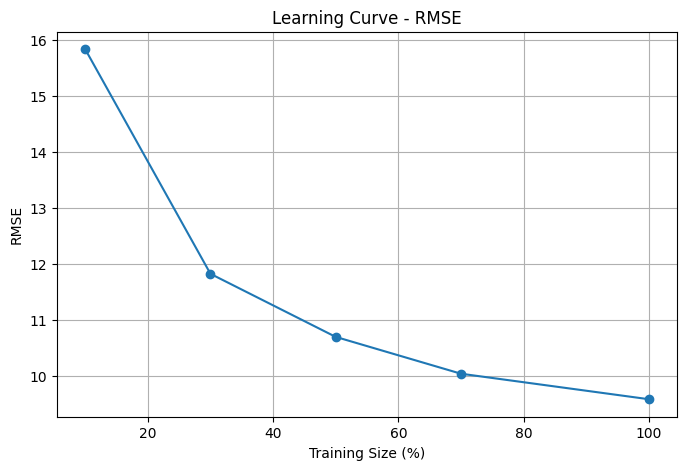

In [14]:
# 1. Sample 10% of the dataset
df_small = df.sample(frac=0.1, random_state=42)

# 2. Define grid parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}


# 3. Instantiate the model
rf_model = RandomForestRegressorModel()

# 4. Run grid search
best, all_results = rf_model.grid_search(
    df_small,
    target_column='ActivePower_Mean',
    param_grid=param_grid,
    primary_metric='RMSE'
)

# 5. Export grid results to Excel
rf_model.export_results('rf_grid_results_small.xlsx')

# 6. Apply best parameters and run final model
rf_model.params.update(best['params'])
final_results = rf_model.run(df_small, target_column='ActivePower_Mean')

# 7. Plot learning curve
rf_model.learning_curve(df_small, target_column='ActivePower_Mean', metric='RMSE')


### Application on full dataset with grid search

In [ ]:
# Step 1: Define grid parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}

# Step 2: Instantiate model
rf_model = RandomForestRegressorModel()

# Step 3: Run grid search on the FULL dataset
best, all_results = rf_model.grid_search(
    df,  # full dataset
    target_column='ActivePower_Mean',
    param_grid=param_grid,
    primary_metric='RMSE'
)

# Step 4: Export full grid search results to Excel
rf_model.export_results(filename='rf_grid_results_full_dataset.xlsx')

# Step 5: Apply best parameters and retrain model on full dataset split
rf_model.params.update(best['params'])
final_results = rf_model.run(df, target_column='ActivePower_Mean')

# Step 6: Plot learning curve for final model
rf_model.learning_curve(df, target_column='ActivePower_Mean', metric='RMSE')
